code to predict pv generation

In [16]:
import numpy as np
import pandas as pd
from scipy.stats import norm, gamma
import matplotlib.pyplot as plt
import scipy.stats as stats
from matplotlib.ticker import MaxNLocator # To ensure demand axis are integer.


from sklearn.model_selection import train_test_split
from sklearn.model_selection import TimeSeriesSplit
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error

import statsmodels.api as sm
from statsmodels.tsa.arima.model import ARIMA
import xgboost as xgb



# Third party packages.
import os                       # Execute tasks related to your operating system.

import polars as pl             # Data handling ('Blazingly fast DataFrames') and is a drop-in replacement for pandas.
import pickle                   # Save and load data to and from pickle files.
import time
import json
import os
import joblib

from icecream import ic         # Print variables.
from datetime import datetime


Data Understanding

Load data set. Split with 80% and 20% split

In [17]:
# Load API Key and download directory from config file
CONFIG_FILE = "../config/api-call.json"

def load_config(config_path):
    """Load configuration from a JSON file."""
    with open(config_path, "r") as file:
        return json.load(file)

# Load config values
config = load_config(CONFIG_FILE)

# print(config)
DOWNLOAD_DIR = config["ned"]["ned_download_dir"]
CSV_DOWNLOAD_DIR = config["ned"]["ned_test_download_dir"]
print("DOWNLOAD_DIR :", DOWNLOAD_DIR)
# pkl_file_path = f'{DOWNLOAD_DIR}/power-gen-type-0.pkl'
csv_file_path = f'{DOWNLOAD_DIR}merge-data-2022-2024.csv'

# with open('../data/dc-ned-json-data-1.pkl', 'rb') as pickle_file:
# with open(pkl_file_path, 'rb') as pickle_file:
with open(csv_file_path, 'rb') as csv_file:
    df_pd_orig = pd.read_csv(csv_file)

# Sum of all columns starting with 'production'
df_pd_orig["Total_Production"] = df_pd_orig.filter(like="production").sum(axis=1)
# df_pd_orig["Total_Production"] = df_pd_orig["production_all"]
df_pd_orig.rename(columns={'date_x': 'validto'}, inplace=True)

# Show a sample of first 3 rows.
df_pd_orig.head(3)


DOWNLOAD_DIR : ../data/powergen/


,index,date,Load,Price,Flow_BE_to_NL,Flow_NL_to_BE,Flow_DE_to_NL,Flow_NL_to_DE,Flow_GB_to_NL,Flow_NL_to_GB,...,production_otherpower,capacity_27,production_electricitymix,capacity_35,production_CHP_total,capacity_50,production_solarthermal,capacity_51,production_allconsuminggas,Total_Production
0,0,2022-01-01 00:00:00+00:00,10249.75,124.7,0.0,728.0,1314.0,425.50,0.0,591.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
1,1,2022-01-01 01:00:00+00:00,9907.00,134.0,0.0,1070.0,1092.0,281.75,0.0,456.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
2,2,2022-01-01 02:00:00+00:00,9782.50,58.8,0.0,344.0,1372.5,849.25,412.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0


Descriptive Statistics

In [18]:
# Using Pandas.
df_pd_num = df_pd_orig.select_dtypes(include='number')

# Column names (Pandas: df_pd_orig_num.columns.tolist()).
l_df_num_names = df_pd_num.columns
print(f"We have {len(l_df_num_names)} numerical variables:\n{l_df_num_names}")

# Convert to datetime format
df_pd_orig_str = df_pd_orig.select_dtypes(include='object')
print("Number of rows:", df_pd_orig_str.shape[0], "and column names are:", df_pd_orig_str.columns, "and column types are:", df_pd_orig_str.dtypes)

We have 72 numerical variables:
Index(['index', 'Load', 'Price', 'Flow_BE_to_NL', 'Flow_NL_to_BE',
       'Flow_DE_to_NL', 'Flow_NL_to_DE', 'Flow_GB_to_NL', 'Flow_NL_to_GB',
       'Flow_DK_to_NL', 'Flow_NL_to_DK', 'Flow_NO_to_NL', 'Flow_NL_to_NO',
       'Flow_BE', 'Flow_DE', 'Flow_GB', 'Flow_DK', 'Flow_NO', 'Total_Flow',
       'temperature_2m', 'apparent_temperature', 'cloud_cover',
       'wind_speed_10m', 'diffuse_radiation', 'direct_normal_irradiance',
       'shortwave_radiation', 'wind_speed_100m', 'capacity_1',
       'production_wind', 'capacity_2', 'production_solar', 'capacity_4',
       'production_heatpump', 'capacity_8', 'production_cofiring',
       'capacity_9', 'production_geothermal', 'capacity_10',
       'production_other', 'capacity_11', 'production_waste', 'capacity_12',
       'production_biooil', 'capacity_13', 'production_biomass', 'capacity_14',
       'production_wood', 'capacity_17', 'production_windoffshore',
       'capacity_18', 'production_fossilgaspowe

To check if the output column has unique values

In [19]:
l_col = ['Price']

for s_col in l_col:
    print(f"{l_col}: {df_pd_orig[l_col]}")
    print(f"{s_col}: {df_pd_orig[s_col].unique()}")

['Price']:         Price
0      124.70
1      134.00
2       58.80
3       37.67
4       39.70
...       ...
26299   59.90
26300   18.20
26301    9.06
26302    0.52
26303   13.62

[26304 rows x 1 columns]
Price: [124.7  134.    58.8  ...  18.2    9.06  13.62]


Contruct a descriptive summary

In [20]:
df_pd_orig.describe()

,index,Load,Price,Flow_BE_to_NL,Flow_NL_to_BE,Flow_DE_to_NL,Flow_NL_to_DE,Flow_GB_to_NL,Flow_NL_to_GB,Flow_DK_to_NL,...,production_otherpower,capacity_27,production_electricitymix,capacity_35,production_CHP_total,capacity_50,production_solarthermal,capacity_51,production_allconsuminggas,Total_Production
count,26304.000000,26303.000000,26301.000000,26303.000000,26303.000000,26303.000000,26303.000000,26301.000000,26301.000000,26303.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,26304.0
mean,13151.500000,12349.026309,138.294566,247.454663,767.337642,809.419353,949.103030,201.165136,430.358833,293.654336,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
std,7593.455077,2038.897514,113.144318,491.021658,817.858597,767.763152,1003.446814,344.765537,442.343338,308.965983,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
min,0.000000,5383.250000,-500.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
25%,6575.750000,10824.500000,75.900000,0.000000,0.000000,79.125000,8.000000,0.000000,0.000000,0.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
50%,13151.500000,12154.750000,106.190000,0.000000,532.000000,690.000000,662.250000,0.000000,287.750000,131.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
75%,19727.250000,13638.750000,174.710000,257.000000,1331.000000,1276.750000,1569.750000,305.500000,946.250000,683.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
max,26303.000000,19477.250000,872.960000,3709.000000,4181.000000,5146.500000,5949.000000,1060.250000,1090.250000,835.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0


Function to capture metrics from prediction models

In [21]:
# Custom function for MAPE and sMAPE
def mean_absolute_percentage_error(y_true, y_pred): 
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def symmetric_mape(y_true, y_pred):
    return np.mean(2 * np.abs(y_true - y_pred) / (np.abs(y_true) + np.abs(y_pred))) * 100

# Function to compute AIC for regression models
def compute_aic(y_true, y_pred, num_params):
    residuals = y_true - y_pred
    mse = np.mean(residuals**2)
    n = len(y_true)
    aic = n * np.log(mse) + 2 * num_params  # AIC formula
    return aic

# List to store results
results = []

Prepare data for prediction

In [22]:
# Step 1: Convert 'validto' column to datetime
df_pd_orig['date'] = pd.to_datetime(df_pd_orig['date'])

# Step 2: Sort the DataFrame by 'validto' to avoid data leakage
df = df_pd_orig.sort_values(by='date')

# Count NaNs in each column
print(df_pd_orig.isna().sum())
# Check if the DataFrame has any NaN values
print(df_pd_orig.isna().any().any())  # True if NaNs exist, False otherwise

# Drop rows with any NaN values
df_pd_orig.interpolate(method='linear', inplace=True)  # Time-based interpolation

'''
nan_totalflow = df_pd_orig['Total_Flow'].isna().sum()
print(nan_totalflow)
nan_temp = df_pd_orig['temperature_2m'].isna().sum()
print(nan_temp)
nan_cloud = df_pd_orig['cloud_cover'].isna().sum()
print(nan_cloud)
'''

# Step 3: Split the data into train and test based on time (using a percentage split)
train_size = int(len(df_pd_orig) * 0.8)  # 80% for training
train = df_pd_orig[:train_size].copy()  # Using the first 80% for training
test = df_pd_orig[train_size:].copy()   # Using the last 20% for testing


index                             0
date                              0
Load                              1
Price                             3
Flow_BE_to_NL                     1
                              ...  
capacity_50                   26304
production_solarthermal       26304
capacity_51                   26304
production_allconsuminggas    26304
Total_Production                  0
Length: 74, dtype: int64
True


/var/folders/gy/xs43v__d0mn25qy5kzxrnkrm0000gn/T/ipykernel_14721/2006998857.py:13: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  df_pd_orig.interpolate(method='linear', inplace=True)  # Time-based interpolation


Use of TImeseries split to avoid data leakage. Then perform prediction using regression models

Mean Absolute Error (MAE): 84.35618889553606
shape: (5_261, 4)
┌───────────────┬────────┬───────────┬───────┐
│ X Values      ┆ Actual ┆ Predicted ┆ Diff  │
│ ---           ┆ ---    ┆ ---       ┆ ---   │
│ array[i64, 1] ┆ f64    ┆ i64       ┆ f64   │
╞═══════════════╪════════╪═══════════╪═══════╡
│ [1716750000]  ┆ 108.96 ┆ 35        ┆ 73.96 │
│ [1716753600]  ┆ 98.41  ┆ 35        ┆ 63.41 │
│ [1716757200]  ┆ 87.5   ┆ 35        ┆ 52.5  │
│ [1716760800]  ┆ 70.29  ┆ 35        ┆ 35.29 │
│ [1716764400]  ┆ 68.96  ┆ 35        ┆ 33.96 │
│ …             ┆ …      ┆ …         ┆ …     │
│ [1735671600]  ┆ 59.9   ┆ -24       ┆ 83.9  │
│ [1735675200]  ┆ 18.2   ┆ -24       ┆ 42.2  │
│ [1735678800]  ┆ 9.06   ┆ -24       ┆ 33.06 │
│ [1735682400]  ┆ 0.52   ┆ -24       ┆ 24.52 │
│ [1735686000]  ┆ 13.62  ┆ -24       ┆ 37.62 │
└───────────────┴────────┴───────────┴───────┘


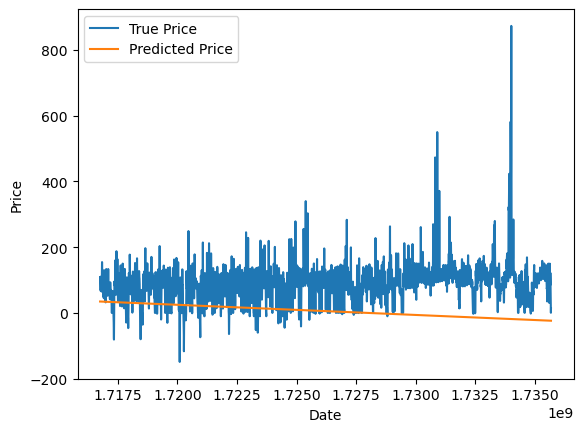

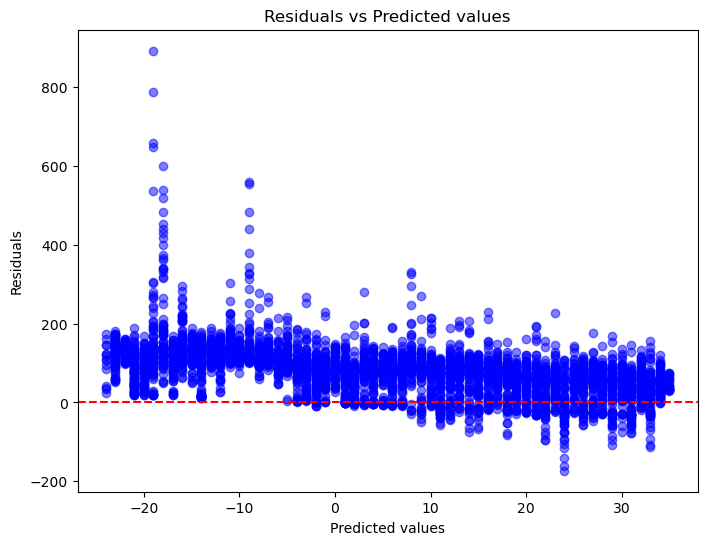

In [23]:
# Step 4: Convert 'validto' (datetime) to numeric format (Unix timestamp in seconds)
train['date_numeric'] = train['date'].astype('int64') // 10**9  # Convert datetime to numeric timestamp
test['date_numeric'] = test['date'].astype('int64') // 10**9

# Step 5: Train the Linear Regression model on 'validto_numeric' column only
X_train = train[['date_numeric']]  # Use 'validto_numeric' as the input
y_train = train['Price']  # 'Total_Production' as the target

model = LinearRegression()
model.fit(X_train, y_train)

# Step 6: Make predictions on the test set
X_test = test[['date_numeric']]
y_test = test['Price']

predictions = model.predict(X_test)
y_int_pred = np.round(predictions).astype(int)  # Rounds and converts to int

# Step 7: Calculate and print performance metrics (e.g., MAE)
mae = mean_absolute_error(y_test, predictions)
print(f"Mean Absolute Error (MAE): {mae}")

# Step 7: Convert Predictions Back to Polars (Optional)
df_pred = pl.DataFrame({"X Values": X_test.values, "Actual": y_test.values, "Predicted": y_int_pred, "Diff": y_test.values - y_int_pred})
print(df_pred)

# Step 8: Visualize the results (optional)
plt.plot(test['date_numeric'], y_test, label='True Price')
plt.plot(test['date_numeric'], predictions, label='Predicted Price')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

aic_lr = compute_aic(y_test, y_int_pred, num_params=X_train.shape[1] + 1)

# Store results
results.append(["Linear Regression", 
                mean_absolute_error(y_test, y_int_pred),
                np.sqrt(mean_squared_error(y_test, y_int_pred)), 
                mean_absolute_percentage_error(y_test, y_int_pred), 
                symmetric_mape(y_test, y_int_pred), 
                aic_lr])

# 2️⃣ ARIMA Model (Example Order: (1,1,1))
arima_model = ARIMA(y_train, order=(1,1,1)).fit()
y_pred_arima = arima_model.forecast(steps=len(y_test))
aic_arima = arima_model.aic  # Directly from ARIMA model

# Store results
results.append(["ARIMA (1,1,1)", 
                mean_absolute_error(y_test, y_pred_arima),
                np.sqrt(mean_squared_error(y_test, y_pred_arima)), 
                mean_absolute_percentage_error(y_test, y_pred_arima), 
                symmetric_mape(y_test, y_pred_arima), 
                aic_arima])

# 1. Calculate residuals
residuals = y_test - y_int_pred

# 2. Plotting the residuals

# a. Residuals vs. Predicted values plot
plt.figure(figsize=(8, 6))
plt.scatter(y_int_pred, residuals, color='blue', alpha=0.5)
plt.axhline(y=0, color='r', linestyle='--')
plt.title('Residuals vs Predicted values')
plt.xlabel('Predicted values')
plt.ylabel('Residuals')
plt.show()


Predict using LASSO model

In [24]:

# Train Lasso Regression Model
lasso = Lasso(alpha=0.2)  # Adjust alpha for regularization strength
lasso.fit(X_train, y_train)
# Make Predictions
y_pred = lasso.predict(X_test)
y_int_pred = np.round(y_pred).astype(int)  # Rounds and converts to int

# Evaluate Model
mae = mean_absolute_error(y_test, y_pred)
print(f"Mean Absolute Error: {mae}")

# Step 7: Convert Predictions Back to Polars (Optional)
df_pred = pl.DataFrame({"X Values": X_test.values, "Actual": y_test.values, "Predicted": y_int_pred, "Diff": y_test.values - y_int_pred})
print(df_pred)

# Store results
results.append(["LASSO", 
                mean_absolute_error(y_test, y_int_pred),
                np.sqrt(mean_squared_error(y_test, y_int_pred)), 
                mean_absolute_percentage_error(y_test, y_int_pred), 
                symmetric_mape(y_test, y_int_pred), 
                aic_lr])


Mean Absolute Error: 84.35618887921189
shape: (5_261, 4)
┌───────────────┬────────┬───────────┬───────┐
│ X Values      ┆ Actual ┆ Predicted ┆ Diff  │
│ ---           ┆ ---    ┆ ---       ┆ ---   │
│ array[i64, 1] ┆ f64    ┆ i64       ┆ f64   │
╞═══════════════╪════════╪═══════════╪═══════╡
│ [1716750000]  ┆ 108.96 ┆ 35        ┆ 73.96 │
│ [1716753600]  ┆ 98.41  ┆ 35        ┆ 63.41 │
│ [1716757200]  ┆ 87.5   ┆ 35        ┆ 52.5  │
│ [1716760800]  ┆ 70.29  ┆ 35        ┆ 35.29 │
│ [1716764400]  ┆ 68.96  ┆ 35        ┆ 33.96 │
│ …             ┆ …      ┆ …         ┆ …     │
│ [1735671600]  ┆ 59.9   ┆ -24       ┆ 83.9  │
│ [1735675200]  ┆ 18.2   ┆ -24       ┆ 42.2  │
│ [1735678800]  ┆ 9.06   ┆ -24       ┆ 33.06 │
│ [1735682400]  ┆ 0.52   ┆ -24       ┆ 24.52 │
│ [1735686000]  ┆ 13.62  ┆ -24       ┆ 37.62 │
└───────────────┴────────┴───────────┴───────┘


Predict using decision tree regression

In [25]:

# Train Decision Tree Regressor Model
dt_regressor = DecisionTreeRegressor(max_depth=3, random_state=42)
dt_regressor.fit(X_train, y_train)

# Make Predictions
y_pred = dt_regressor.predict(X_test)
y_int_pred = np.round(y_pred).astype(int)  # Rounds and converts to int

# Evaluate Model
mae = mean_absolute_error(y_test, y_pred)
print(f"Mean Absolute Error: {mae}")

# Step 7: Convert Predictions Back to Polars (Optional)
df_pred = pl.DataFrame({"X Values": X_test.values, "Actual": y_test.values, "Predicted": y_int_pred, "Diff": y_test.values - y_int_pred})
print(df_pred)

# Store results
results.append(["Decision Tree", 
                mean_absolute_error(y_test, y_int_pred),
                np.sqrt(mean_squared_error(y_test, y_int_pred)), 
                mean_absolute_percentage_error(y_test, y_int_pred), 
                symmetric_mape(y_test, y_int_pred), 
                aic_lr])



Mean Absolute Error: 43.7257996278345
shape: (5_261, 4)
┌───────────────┬────────┬───────────┬────────┐
│ X Values      ┆ Actual ┆ Predicted ┆ Diff   │
│ ---           ┆ ---    ┆ ---       ┆ ---    │
│ array[i64, 1] ┆ f64    ┆ i64       ┆ f64    │
╞═══════════════╪════════╪═══════════╪════════╡
│ [1716750000]  ┆ 108.96 ┆ 63        ┆ 45.96  │
│ [1716753600]  ┆ 98.41  ┆ 63        ┆ 35.41  │
│ [1716757200]  ┆ 87.5   ┆ 63        ┆ 24.5   │
│ [1716760800]  ┆ 70.29  ┆ 63        ┆ 7.29   │
│ [1716764400]  ┆ 68.96  ┆ 63        ┆ 5.96   │
│ …             ┆ …      ┆ …         ┆ …      │
│ [1735671600]  ┆ 59.9   ┆ 63        ┆ -3.1   │
│ [1735675200]  ┆ 18.2   ┆ 63        ┆ -44.8  │
│ [1735678800]  ┆ 9.06   ┆ 63        ┆ -53.94 │
│ [1735682400]  ┆ 0.52   ┆ 63        ┆ -62.48 │
│ [1735686000]  ┆ 13.62  ┆ 63        ┆ -49.38 │
└───────────────┴────────┴───────────┴────────┘


Predit using Random Forest regressor

In [26]:

# Train Random Forest Regressor Model
rf_regressor = RandomForestRegressor(n_estimators=10000, random_state=42)  # 100 trees in the forest
rf_regressor.fit(X_train, y_train)

# Make Predictions
y_pred = rf_regressor.predict(X_test)
y_int_pred = np.round(y_pred).astype(int)  # Rounds and converts to int

# Evaluate Model
mae = mean_absolute_error(y_test, y_pred)
print(f"Mean Absolute Error: {mae}")

# Print Predictions
df_pred = pl.DataFrame({"X Values": X_test.values, "Actual": y_test.values, "Predicted": y_int_pred, "Diff": y_test.values - y_int_pred})
print(df_pred)
'''
MODEL_DOWNLOAD_DIR = config["ned"]["ned_model_download_dir"]
model_pkl_file_path = f'{MODEL_DOWNLOAD_DIR}power-gen-random-forest-model-0.pkl'
print("model_pkl_file_path :", model_pkl_file_path)

# Save the trained model
joblib.dump(rf_regressor, model_pkl_file_path, compress=3)
print("Model saved successfully!")''
'''

# Store results
results.append(["Random Forest", 
                mean_absolute_error(y_test, y_int_pred),
                np.sqrt(mean_squared_error(y_test, y_int_pred)), 
                mean_absolute_percentage_error(y_test, y_int_pred), 
                symmetric_mape(y_test, y_int_pred), 
                aic_lr])

Mean Absolute Error: 39.39366745827739
shape: (5_261, 4)
┌───────────────┬────────┬───────────┬─────────┐
│ X Values      ┆ Actual ┆ Predicted ┆ Diff    │
│ ---           ┆ ---    ┆ ---       ┆ ---     │
│ array[i64, 1] ┆ f64    ┆ i64       ┆ f64     │
╞═══════════════╪════════╪═══════════╪═════════╡
│ [1716750000]  ┆ 108.96 ┆ 105       ┆ 3.96    │
│ [1716753600]  ┆ 98.41  ┆ 105       ┆ -6.59   │
│ [1716757200]  ┆ 87.5   ┆ 105       ┆ -17.5   │
│ [1716760800]  ┆ 70.29  ┆ 105       ┆ -34.71  │
│ [1716764400]  ┆ 68.96  ┆ 105       ┆ -36.04  │
│ …             ┆ …      ┆ …         ┆ …       │
│ [1735671600]  ┆ 59.9   ┆ 105       ┆ -45.1   │
│ [1735675200]  ┆ 18.2   ┆ 105       ┆ -86.8   │
│ [1735678800]  ┆ 9.06   ┆ 105       ┆ -95.94  │
│ [1735682400]  ┆ 0.52   ┆ 105       ┆ -104.48 │
│ [1735686000]  ┆ 13.62  ┆ 105       ┆ -91.38  │
└───────────────┴────────┴───────────┴─────────┘


XGBoost Model

XGBoost MAE: 11.926440336769058


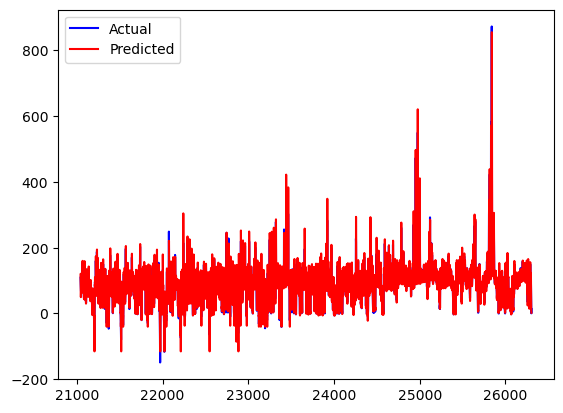

In [27]:
# Create lag features
df_pd_orig['lag1'] = df_pd_orig['Price'].shift(1)
df_pd_orig['lag2'] = df_pd_orig['Price'].shift(2)
df.dropna(inplace=True)

# Train-Test Split
X = df_pd_orig[['lag1', 'lag2']]
y = df_pd_orig['Price']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# Train XGBoost Model
model = xgb.XGBRegressor(objective="reg:squarederror", n_estimators=100)
model.fit(X_train, y_train)

# Predict and Evaluate
y_pred = model.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
print("XGBoost MAE:", mae)

# Plot Results
import matplotlib.pyplot as plt
plt.plot(y_test.index, y_test, label="Actual", color="blue")
plt.plot(y_test.index, y_pred, label="Predicted", color="red")
plt.legend()
plt.show()

# Compute evaluation metrics
mae_xgb = mean_absolute_error(y_test, y_pred)
rmse_xgb = np.sqrt(mean_squared_error(y_test, y_pred))
mape_xgb = mean_absolute_percentage_error(y_test, y_pred)
smape_xgb = symmetric_mape(y_test, y_pred)
aic_xgb = compute_aic(y_test, y_pred, num_params=X_train.shape[1] + 1)

# Append results to results
results.append(["XGBoost", mae_xgb, rmse_xgb, mape_xgb, smape_xgb, aic_xgb])


LTSM (Long Short-Term Memory)

/opt/miniconda3/envs/enexis-mar-visualization/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/20
1315/1315 ━━━━━━━━━━━━━━━━━━━━ 21s 12ms/step - loss: 0.0156
Epoch 2/20
1315/1315 ━━━━━━━━━━━━━━━━━━━━ 13s 10ms/step - loss: 9.5013e-04
Epoch 3/20
1315/1315 ━━━━━━━━━━━━━━━━━━━━ 12s 9ms/step - loss: 4.6966e-04
Epoch 4/20
1315/1315 ━━━━━━━━━━━━━━━━━━━━ 11s 9ms/step - loss: 3.8033e-04
Epoch 5/20
1315/1315 ━━━━━━━━━━━━━━━━━━━━ 12s 9ms/step - loss: 3.8736e-04
Epoch 6/20
1315/1315 ━━━━━━━━━━━━━━━━━━━━ 12s 9ms/step - loss: 3.7187e-04
Epoch 7/20
1315/1315 ━━━━━━━━━━━━━━━━━━━━ 12s 9ms/step - loss: 3.8207e-04
Epoch 8/20
1315/1315 ━━━━━━━━━━━━━━━━━━━━ 11s 9ms/step - loss: 3.5638e-04
Epoch 9/20
1315/1315 ━━━━━━━━━━━━━━━━━━━━ 20s 8ms/step - loss: 3.4858e-04
Epoch 10/20
1315/1315 ━━━━━━━━━━━━━━━━━━━━ 11s 9ms/step - loss: 3.3486e-04
Epoch 11/20
1315/1315 ━━━━━━━━━━━━━━━━━━━━ 11s 8ms/step - loss: 3.4913e-04
Epoch 12/20
1315/1315 ━━━━━━━━━━━━━━━━━━━━ 11s 8ms/step - loss: 3.4542e-04
Epoch 13/20
1315/1315 ━━━━━━━━━━━━━━━━━━━━ 12s 9ms/step - loss: 3.3225e-04
Epoch 14/20
1315/1315 ━━━━━━━━━━━━━━

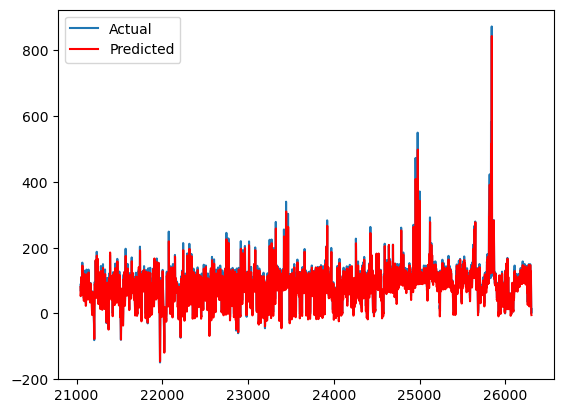

In [28]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.preprocessing import MinMaxScaler

# Load dataset
df = df_pd_orig

# Normalize data
scaler = MinMaxScaler()
df['Price'] = scaler.fit_transform(df[['Price']])

# Create sequences for LSTM
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i: i + seq_length])
        y.append(data[i + seq_length])
    return np.array(X), np.array(y)

seq_length = 10  # Lookback period
data = df['Price'].values
X, y = create_sequences(data, seq_length)

# Split into train/test sets
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Build LSTM Model
model = Sequential([
    LSTM(50, activation='relu', return_sequences=True, input_shape=(seq_length, 1)),
    LSTM(50, activation='relu'),
    Dense(1)
])

# Compile & Train
model.compile(optimizer='adam', loss='mse')
model.fit(X_train, y_train, epochs=20, batch_size=16, verbose=1)

# Predict & Inverse Transform
y_pred = model.predict(X_test)
y_pred = scaler.inverse_transform(y_pred)

# Compute evaluation metrics
mae_ltsm = mean_absolute_error(y_test, y_pred)
rmse_ltsm = np.sqrt(mean_squared_error(y_test, y_pred))
mape_ltsm = mean_absolute_percentage_error(y_test, y_pred)
smape_ltsm = symmetric_mape(y_test, y_pred)
aic_ltsm = compute_aic(y_test, y_pred, num_params=X_train.shape[1] + 1)

print(mae_ltsm, rmse_ltsm, mape_ltsm, smape_ltsm, aic_ltsm)

# Append results to results
results.append(["LSTM", mae_ltsm, rmse_ltsm, mape_ltsm, smape_ltsm, aic_ltsm])

# Plot Results
import matplotlib.pyplot as plt
plt.plot(df.index[-len(y_test):], scaler.inverse_transform(y_test.reshape(-1,1)), label="Actual")
plt.plot(df.index[-len(y_test):], y_pred, label="Predicted", color="red")
plt.legend()
plt.show()


Print Model evaluation results

In [29]:
# Convert results to DataFrame
metrics_df = pd.DataFrame(results, columns=["Model", "MAE", "RMSE", "MAPE", "sMAPE", "AIC"])

# Display Table
print(metrics_df)

               Model        MAE        RMSE          MAPE       sMAPE  \
0  Linear Regression  84.356941  101.254394           inf  161.547610   
1      ARIMA (1,1,1)  47.947656   66.080306           inf   55.626071   
2              LASSO  84.356941  101.254394           inf  161.547610   
3      Decision Tree  43.961474   60.069413           inf   62.842224   
4      Random Forest  39.578216   59.261037           inf   50.247124   
5            XGBoost  11.926440   20.656868           inf   25.677563   
6               LSTM  79.183946   93.387049  1.873713e+04  195.262730   

             AIC  
0   48590.767028  
1  197493.013265  
2   48590.767028  
3   48590.767028  
4   48590.767028  
5   31867.119522  
6   47741.993695  
